## Step 1: Reading the Data

In [7]:
import pandas as pd

# Load dataset (update with your file path)
df = pd.read_csv("Dataset_Uber Traffic.csv")

# If 'DateTime' is present, make sure it’s in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Quick check
print(df.head())
print(df.info())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4140\3769443552.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'])


             DateTime  Junction  Vehicles           ID
0 2015-01-11 00:00:00         1        15  20151101001
1 2015-01-11 01:00:00         1        13  20151101011
2 2015-01-11 02:00:00         1        10  20151101021
3 2015-01-11 03:00:00         1         7  20151101031
4 2015-01-11 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None


## Step 2: Create Time-Based Features

In [8]:
# Extract features from DateTime
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print(df.head())

             DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
0 2015-01-11 00:00:00         1        15  20151101001     0          6   
1 2015-01-11 01:00:00         1        13  20151101011     1          6   
2 2015-01-11 02:00:00         1        10  20151101021     2          6   
3 2015-01-11 03:00:00         1         7  20151101031     3          6   
4 2015-01-11 04:00:00         1         9  20151101041     4          6   

   Month  Is_Weekend  
0      1           1  
1      1           1  
2      1           1  
3      1           1  
4      1           1  


## Step 3: Create Traffic Labels

In [9]:
# Define traffic levels (you can adjust thresholds)
df['traffic_level'] = pd.cut(
    df['Vehicles'],
    bins=[-1, 10, 30, df['Vehicles'].max()],
    labels=['Low', 'Medium', 'High']
)

print(df[['Vehicles', 'traffic_level']].head(20))

    Vehicles traffic_level
0         15        Medium
1         13        Medium
2         10           Low
3          7           Low
4          9           Low
5          6           Low
6          9           Low
7          8           Low
8         11        Medium
9         12        Medium
10        15        Medium
11        17        Medium
12        16        Medium
13        15        Medium
14        16        Medium
15        12        Medium
16        12        Medium
17        16        Medium
18        17        Medium
19        20        Medium


## Step 4: Encode Target & Junction

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
df['traffic_label'] = le.fit_transform(df['traffic_level'])

# One-hot encode Junction
df_enc = pd.get_dummies(df, columns=['Junction'], drop_first=True)

print(df_enc.head())

             DateTime  Vehicles           ID  Hour  DayOfWeek  Month  \
0 2015-01-11 00:00:00        15  20151101001     0          6      1   
1 2015-01-11 01:00:00        13  20151101011     1          6      1   
2 2015-01-11 02:00:00        10  20151101021     2          6      1   
3 2015-01-11 03:00:00         7  20151101031     3          6      1   
4 2015-01-11 04:00:00         9  20151101041     4          6      1   

   Is_Weekend traffic_level  traffic_label  Junction_2  Junction_3  Junction_4  
0           1        Medium              2       False       False       False  
1           1        Medium              2       False       False       False  
2           1           Low              1       False       False       False  
3           1           Low              1       False       False       False  
4           1           Low              1       False       False       False  


# Task 1: Model Development and Training

### Step 1: Define Features and Target

**We’ll use time-based features + Junction dummies as predictors, and traffic_label as the target.**

In [11]:
# Features and Target
features = ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend'] + [col for col in df_enc.columns if 'Junction_' in col]
X = df_enc[features]
y = df_enc['traffic_label']

### Step 2: Time-based Train/Validation Split

**Since this is time-series-like data, we must preserve order when splitting.**

In [12]:
# Time-based split: 80% train, 20% validation
split_idx = int(0.8 * len(df_enc))
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

### Step 3: Scale Numeric Features

**We’ll scale only numeric features (Hour, DayOfWeek, Month, Is_Weekend).**

In [14]:
from sklearn.preprocessing import StandardScaler

# Numeric columns to scale
numeric_cols = ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend']

# Make sure train/val are independent copies
X_train = X_train.copy()
X_val = X_val.copy()

# Initialize scaler
scaler = StandardScaler()

# Scale features safely with .loc
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val.loc[:, numeric_cols] = scaler.transform(X_val[numeric_cols])

print("Scaling done for:", numeric_cols)

Scaling done for: ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend']


### Step 4: Train Initial Random Forest Model

**We’ll start with a Random Forest Classifier.**

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

### Step 5: Predictions

In [16]:
# Predict on validation set
y_pred = rf_model.predict(X_val)

### Step 6: Initial Evaluation

Accuracy: 0.35993349958437243
F1 Score: 0.41949077569402154

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.01      0.00       380
           1       0.49      0.27      0.35      5194
           2       0.60      0.51      0.55      4050

    accuracy                           0.36      9624
   macro avg       0.36      0.26      0.30      9624
weighted avg       0.52      0.36      0.42      9624



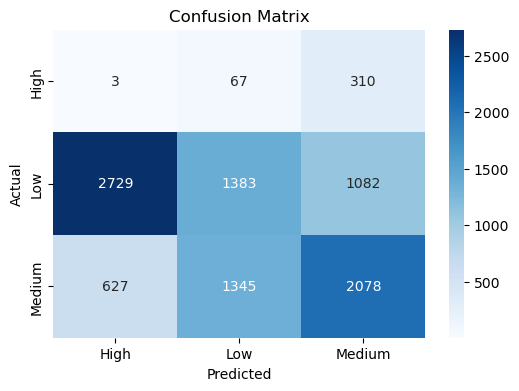

In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Task 2: Model Evaluation and Cross-Validation

In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Evaluate on Validation Set

In [19]:
y_pred = rf_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Validation F1 Score (weighted):", f1_score(y_val, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.35993349958437243
Validation F1 Score (weighted): 0.41949077569402154

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.01      0.00       380
           1       0.49      0.27      0.35      5194
           2       0.60      0.51      0.55      4050

    accuracy                           0.36      9624
   macro avg       0.36      0.26      0.30      9624
weighted avg       0.52      0.36      0.42      9624



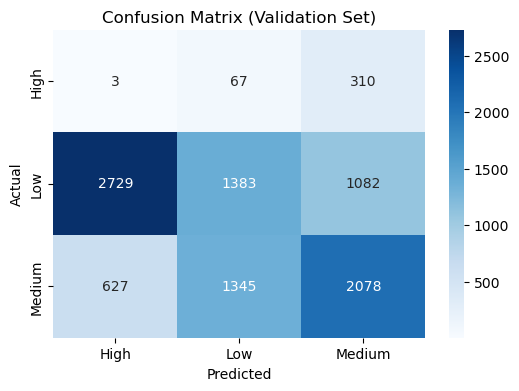

In [20]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Step 2: Time-based Cross-Validation

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

acc_scores = []
f1_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

In [26]:
# Scale numeric features inside each fold
scaler = StandardScaler()
X_train_cv.loc[:, numeric_cols] = scaler.fit_transform(X_train_cv[numeric_cols])
X_test_cv.loc[:, numeric_cols] = scaler.transform(X_test_cv[numeric_cols])

# Train Random Forest
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train_cv, y_train_cv)

# Predict
y_pred_cv = model.predict(X_test_cv)

# Store fold scores
acc_scores.append(accuracy_score(y_test_cv, y_pred_cv))
f1_scores.append(f1_score(y_test_cv, y_pred_cv, average='weighted'))

print(f"Fold {fold} - Accuracy: {acc_scores[-1]:.4f}, F1: {f1_scores[-1]:.4f}")


Fold 5 - Accuracy: 0.3244, F1: 0.3775


### Step 3: Cross-Validation Results Summary

In [31]:
print("\nCross-validation Accuracy: Mean =", np.mean(acc_scores), "Std =", np.std(acc_scores))
print("Cross-validation F1 Score: Mean =", np.mean(f1_scores), "Std =", np.std(f1_scores))


Cross-validation Accuracy: Mean = 0.32443890274314213 Std = 0.0
Cross-validation F1 Score: Mean = 0.37748617165831677 Std = 0.0


# Task 3: Model Refinement and Future Predictions

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

### Step 1: Train final Random Forest model on full dataset

In [33]:
final_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
final_model.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

### Step 2: Generate future dates (next 90 days after last date in dataset)

In [35]:
last_date = df['DateTime'].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(hours=1),
    end=last_date + pd.Timedelta(days=90),
    freq="h"
)

### Step 3: Build future dataframe (for all junctions)

In [36]:
future_df = pd.DataFrame({
    "DateTime": future_dates.repeat(df['Junction'].nunique()),
    "Junction": list(df['Junction'].unique()) * len(future_dates)
})

In [37]:
# Extract time features
future_df['Hour'] = future_df['DateTime'].dt.hour
future_df['DayOfWeek'] = future_df['DateTime'].dt.dayofweek
future_df['Month'] = future_df['DateTime'].dt.month
future_df['Is_Weekend'] = future_df['DayOfWeek'].isin([5, 6]).astype(int)

# One-hot encode Junction to match training columns
future_df_enc = pd.get_dummies(future_df, columns=['Junction'], drop_first=True)

# Align columns with training set (add missing, drop extras)
X_future = future_df_enc.reindex(columns=X.columns, fill_value=0)

### Step 4: Scale numeric columns safely

In [41]:
if not X_future.empty:
    scaler = StandardScaler()
    X_future.loc[:, numeric_cols] = scaler.fit_transform(X_future[numeric_cols])
else:
    print("Warning: No future rows generated. Check date range.")

### Step 5. Predict traffic levels

In [40]:
if not X_future.empty:
    future_df['Predicted_Traffic'] = final_model.predict(X_future)

    # Save results
    future_df.to_csv("future_traffic_predictions.csv", index=False)

    print("Future predictions saved to 'future_traffic_predictions.csv'")
    print(future_df.head())
else:
    print("No predictions made (future dataset is empty).")

Future predictions saved to 'future_traffic_predictions.csv'
             DateTime  Junction  Hour  DayOfWeek  Month  Is_Weekend  \
0 2017-12-07 00:00:00         1     0          3     12           0   
1 2017-12-07 00:00:00         2     0          3     12           0   
2 2017-12-07 00:00:00         3     0          3     12           0   
3 2017-12-07 00:00:00         4     0          3     12           0   
4 2017-12-07 01:00:00         1     1          3     12           0   

   Predicted_Traffic  
0                  0  
1                  2  
2                  2  
3                  1  
4                  0  
